In [1]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home/users/kokron/Libraries/lim')
from lim import lim
import numpy as np
import astropy.units as u
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
import matplotlib
from scipy.optimize import curve_fit
import source.tools._utils as ut
import source.tools._vid_tools as vut
import time

palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

In [2]:
def linear(col1,col2):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [col1,col2])
    return cmap

def SFR_Mz_2dinterp(M,z,SFR_file):
    '''
    Returns SFR(M,z) interpolated from tables of 1+z, log10(Mhalo/Msun) and 
    log10(SFR / (Msun/yr)), in three columns, where 1+z is the innermost index 
    (the one running fast compared with the mass)
    '''
    #SFR_folder = os.path.dirname(os.path.realpath(__file__)).split("source")[0]+'SFR_tables/'
    #try:
    #    x = np.loadtxt(SFR_folder+SFR_file)
    #except:
    x = np.loadtxt(SFR_file)
    zb = np.unique(x[:,0])-1.
    logMb = np.unique(x[:,1])
    logSFRb = x[:,2].reshape(len(zb),len(logMb),order='F')
    
    logSFR_interp = interp2d(logMb,zb,logSFRb,bounds_error=False,fill_value=-40.)
    
    if 'sfr_table_Behroozi' in SFR_file:
        M *= 0.678
        
    try:
        logM = np.log10((M).value)
    except:
        logM = np.log10(M)
    if np.array(z).size>1:
        SFR = np.zeros(logM.size)
        for ii in range(0,logM.size):
            SFR[ii] = 10.**logSFR_interp(logM[ii],z[ii])
    else:
        SFR = 10.**logSFR_interp(logM,z)
    
    return SFR

def Gauss(x,mu,sig2):
    '''
    Gaussian PDF
    '''
    exparg = -0.5*x**2/sig2
    norm = (2.*np.pi*sig2)**0.5
    return np.exp(exparg)/norm

def Add_noise(T,Tout,PT,Pzero,sig2):
    '''
    Adds a noise PDF to a given PDF convoluting them
    
    params: 
    T: temperature vector
    PT: PDF of temperature
    Pzero: The value of P(T=0) (i.e., P(N=0))
    sig2: variance of the noise PDF
    '''
    conv = np.zeros(len(Tout))*PT.unit
    for i in range(len(Tout)):
        conv[i] = np.trapz(Gauss(Tout[i]-T,0.,sig2)*PT,T)
    conv += Pzero*Gauss(Tout,0.,sig2)
    
    return conv

def get_VID(M, NTbins):
    #Compute Bnoise
    sig2 = M.sigma_N**2
    Nsigma = 7
    Tmax = max(Nsigma*sig2.value**0.5,M.T[-1].value)
    TTe = np.linspace(-Nsigma*sig2.value**0.5,Tmax,2**15)*M.T.unit
    TT = vut.binedge_to_binctr(TTe)
    dTT = np.diff(TTe)

    PTN = Gauss(TT,0.,sig2).to((TT**-1).unit)

    Tmin_i,Tmax_i,nT_i = -15*u.K,50*u.K,NTbins
    Tbin_edge=np.linspace(Tmin_i, Tmax_i, nT_i+1)
    Tbin=(Tbin_edge[:-1]+Tbin_edge[1:])/2.

    n0=int(2e5)
    TT2=np.concatenate((np.linspace(-Nsigma*sig2.value**0.5,0,n0)*M.T.unit,M.T))
    ind_mean=int(np.argmin(np.abs(TT2-M.Tmean)))
    PT=np.concatenate((np.concatenate((np.zeros(n0-(ind_mean-n0))*M.PT.unit,M.PT)), np.zeros(ind_mean-n0)*M.PT.unit))
    #TT2=np.concatenate((np.linspace(-Nsigma*sig2.value**0.5,0,400)*M.T.unit,M.T))
    #PT=np.concatenate((np.zeros(400)*M.PT.unit,M.PT))
    
    #get PTtot convoluting both
    Toute = np.linspace(-Nsigma*sig2.value**0.5,M.Tedge[-1].value,2**8+1)*M.T.unit
    #TTe = np.logspace(np.log10(M.Tedge[0].value),np.log10(M.Tedge[-1].value),2**15+1)*M.T.unit
    Tout = vut.binedge_to_binctr(Toute)

    PT_total = Add_noise(TT2,Tout,PT,M.PT_zero,sig2)

    Balpha_tot_overNvox = vut.pdf_to_histogram(Tout,PT_total,Tbin_edge,1,0.*Tbin.unit,0.)
    Bi=Balpha_tot_overNvox*M.Nvox
    
    return Tbin, Bi

# Setting parameters

In [3]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)

def lim_params(SFR_file,  Tsys):
    #Setting line model and observational parameters. Default with RSD, smooth, one_halo, at z=2.5.
    cosmo_fid = dict(cosmo_input_camb={'H0':67.8,'ombh2':0.02312,'omch2':0.118002988,
                      'As':2.23832e-9,'ns':0.96,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100
        
    nu=115.271*u.GHz
    Z=2.9
    DZ=1
    nuObs, Dnu = Dnu_from_Dz(nu, Z, DZ)
    model_params = dict(nu=115.271*u.GHz, nuObs=nuObs, 
                        sigma_scatter=0.3,
                        hmf_model='Tinker', 
                        bias_model='Tinker10', 
                        model_type='ML',
                        Mmin = 1e10/h*u.Msun, Mmax=1e15/h*u.Msun,
                        model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file=SFR_file,sig_SFR=0.5),
                        model_name='TonyLi', 
                        do_onehalo=True, do_RSD=True, smooth=True, 
                        kmin=1e-5*u.Mpc**-1, kmax=1e3*u.Mpc**-1, 
                        nk=512, nmu=10, 
                        Tmin_VID=0.00001*u.uK,Tmax_VID=100*u.uK,nT=2**21,
                        Lmin=1e-2*u.Lsun,Lmax=1e10*u.Lsun,Ngal_max=30,
                        dndL_Lcut=20*u.Lsun)
    obs_params = dict(Delta_nu=Dnu, dnu=15.6*u.MHz, 
                      Tsys_NEFD=Tsys*u.K, 
                      Nfeeds=1000, 
                      beam_FWHM=4*u.arcmin, 
                      tobs=10000*u.hr,
                      Omega_field=11.1*u.deg**2, 
                      Nfield=1)
    obs_params.update(model_params)
    obs_params.update(cosmo_fid)
    return obs_params

def LC_params(do_exSFR, exSFR, exSFR_pars, Tsys):
    nu_CO=115.271*u.GHz
    z_min = 2.4
    z_max = 3.4
    model_params=dict(halo_lightcone_dir='/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/', 
                      lines=dict(CO=True),
                      models=dict(CO=dict(model_name='CO_Li16',
                                          model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                      do_external_SFR = do_exSFR, external_SFR = exSFR,
                      SFR_pars=exSFR_pars,
                      supersample=1,
                      Nmu=10,
                      dk=0.02*u.Mpc**-1)
    obs_params=dict(zmin = z_min-0.03, zmax = z_max+0.03,
                    RAObs_min=-3.3333*u.deg,RAObs_max=0*u.deg,
                    DECObs_min=-3.3333*u.deg,DECObs_max=0*u.deg,
                    RA_min=-3.333333*u.deg,RA_max=0*u.deg,
                    DEC_min=-3.33333*u.deg,DEC_max=0*u.deg,
                    nuObs_max=nu_CO/(1+z_min), nuObs_min=nu_CO/(1+z_max),
                    beam_FWHM=4*u.arcmin, 
                    dnu=15.6*u.MHz,
                    Tsys=Tsys*u.K, 
                    Nfeeds=1000, 
                    tobs=10000*u.hr,
                    linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK,
                    do_smooth=True)
    obs_params.update(model_params)
    return obs_params

def sfr_dc(m, A, B, C, M_h):
    '''
    Parametrization for SFR(M) based off of 2111.05931 parametrization.
    Equation is: 
    
    SFR(M) = C / ((M/M_h)**A + (M/M_h)**B)
    
    so
    A = low-M slope
    B = high-M slope
    C = amplitude at tilt scale
    M_h = tilt mass
    
    
    Note original use is for L_CO (M_h) but here we'll 
    choose SFR(M_h) instead. Should be equivalent but double check.
    '''
    ratio = m/10**M_h
    
    return np.log10(C/(ratio**A + ratio**B))

# lim_params('../SFR_tables/sfr_table_Behroozi.dat', 10)

In [4]:
lcdir = '/home/users/kokron/scratch/'


maps_fid = np.load(lcdir+'maps_cut_fid.npy')

maps_plus = np.load(lcdir + 'maps_cut_Bplus.npy')

maps_minus = np.load(lcdir+'maps_cut_Bminus.npy')

In [5]:
m_bwc = lim(lim_params('../SFR_tables/sfr_table_Behroozi.dat', 10))
m_um = lim(lim_params('../SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean_solMass.dat', 10))

logM=np.log10(m_bwc.M.value)
logM=np.log10(m_bwc.M.value)

sfr_um = SFR_Mz_2dinterp(10**logM, m_bwc.z,'../SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean_solMass.dat')
sfr_bwc = SFR_Mz_2dinterp(10**logM,m_bwc.z,'../SFR_tables/sfr_table_Behroozi.dat')          

popt_um, pcov = curve_fit(sfr_dc, 10**logM[np.logical_and(np.log10(sfr_um)>-3 , logM>10.5)], np.log10(sfr_um)[np.logical_and(np.log10(sfr_um)>-3, logM>10.5)],
                         p0=[3,-1.4,10,12.5])
popt_bwc, pcov = curve_fit(sfr_dc, 10**logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3],
                          p0=[3,-1.4,10,12.5])

/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


(-2, 3)

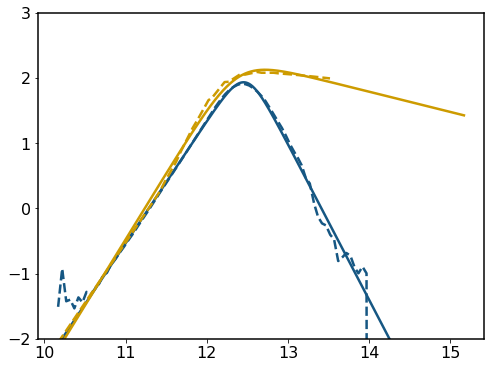

In [6]:
A_um, B_um, C_um, Mh_um = popt_um
plt.plot(logM,sfr_dc(10**logM, A_um, B_um, C_um, Mh_um), 'C0')
plt.plot(logM, np.log10(sfr_um), 'C0--')

A_bwc, B_bwc, C_bwc, Mh_bwc = popt_bwc
plt.plot(logM, sfr_dc(10**logM, A_bwc, B_bwc, C_bwc, Mh_bwc), 'C1')
plt.plot(logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3], '--C1')

plt.ylim(-2, 3)

# Compute VIDs

Loading in the derivative maps and reshaping them for varying numbers of nbins.

In [7]:
#Step size in one direction for each of the parameters in question
stepvec = np.array([0.01, 0.01, 0.01, 0.005])


map_fid = np.load('/home/users/kokron/scratch/maps_cut_fid.npy')


Nfields=[16, 26, 36]


Bi_N10=[]; deriv_N10=[]
Bi_N25=[]; deriv_N25=[]
Bi_N50=[]; deriv_N50=[]
T10_edge=np.linspace(-15, 50, 11)
T10=(T10_edge[:-1]+T10_edge[1:])/2.
T25_edge=np.linspace(-15, 50, 26)
T25=(T25_edge[:-1]+T25_edge[1:])/2.
T50_edge=np.linspace(-15, 50, 51)
T50=(T50_edge[:-1]+T50_edge[1:])/2.



st = time.time()

for param in [0,1,2,3]:
  
    deriv10_cut=[]; deriv25_cut=[]; deriv50_cut=[]

    Bi10_cut=[]; Bi25_cut=[]; Bi50_cut=[]

    maps_plus = np.load('/home/users/kokron/scratch/maps_cut_%dplus.npy'%param)
    
    maps_min = np.load('/home/users/kokron/scratch/maps_cut_%dminus.npy'%param)
    
    for n in range(36):
    
        Bi10_plus=np.histogram(maps_plus[n].flatten(), bins=T10_edge)[0]
        Bi10_minus=np.histogram(maps_minus[n].flatten(), bins=T10_edge)[0]
        Bi25_plus=np.histogram(maps_plus[n].flatten(), bins=T25_edge)[0]
        Bi25_minus=np.histogram(maps_minus[n].flatten(), bins=T25_edge)[0]
        Bi50_plus=np.histogram(maps_plus[n].flatten(), bins=T50_edge)[0]
        Bi50_minus=np.histogram(maps_minus[n].flatten(), bins=T50_edge)[0]

        deriv10_cut.append((Bi10_plus-Bi10_minus)/(2*B_bwc*stepvec[param]))
        deriv25_cut.append((Bi25_plus-Bi25_minus)/(2*B_bwc*stepvec[param]))
        deriv50_cut.append((Bi50_plus-Bi50_minus)/(2*B_bwc*stepvec[param]))

        Bi10_cut.append(np.histogram(maps_fid[n].flatten(), bins=T10_edge)[0])
        Bi25_cut.append(np.histogram(maps_fid[n].flatten(), bins=T25_edge)[0])
        Bi50_cut.append(np.histogram(maps_fid[n].flatten(), bins=T50_edge)[0])


    deriv_N10.append(np.average(deriv10_cut, axis=0))
    deriv_N25.append(np.average(deriv25_cut, axis=0))
    deriv_N50.append(np.average(deriv50_cut, axis=0))
    
    if param == 0:
        Bi_N10.append(np.average(Bi10_cut, axis=0))
        Bi_N25.append(np.average(Bi25_cut, axis=0))
        Bi_N50.append(np.average(Bi50_cut, axis=0))
    print(st - time.time())

deriv_N10 = np.array(deriv_N10)
deriv_N25 = np.array(deriv_N25)
deriv_N50 = np.array(deriv_N50)

-178.2937297821045
-368.72363901138306
-577.2703714370728
-768.5514984130859


# Load in P(k)

In [8]:
fidpk = np.load('../fid_pk.npy')

kvals = fidpk[0]

fidpk = fidpk[1:]

kmax = 0.6

kmask = kvals < kmax


pk_deriv = []


for param in [0,1,2,3]:
    pk_cut = []
    
    pk_plus = np.load('../pk_%dplus.npy'%param)
    pk_min = np.load('../pk_%dminus.npy'%param)
    
    for n in range(36):
        pk_cut.append((pk_plus - pk_min)[n, kmask]/(2*stepvec[param]))
    pk_cut = np.array(pk_cut)
    
    pk_deriv.append(np.mean(pk_cut, axis=0))
    
pk_deriv = np.array(pk_deriv)
#     pk_deri

/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


# Get P(k) covariance

In [9]:
model_bwc=dict(A=A_bwc, B=B_bwc, C=C_bwc, M_h=10**Mh_bwc)

LC = make_measurements(LC_params(True, 'Dongwoo_SFR', model_bwc, 10))
LC.Pk_2d


/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_158.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_159.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_160.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_161.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_162.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_163.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_164.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_165.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_166.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_167.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_168.fits

# Testing poisson variance for nbins:

Note: redshifts have been re-sorted (earliest first)


/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:701: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:702: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


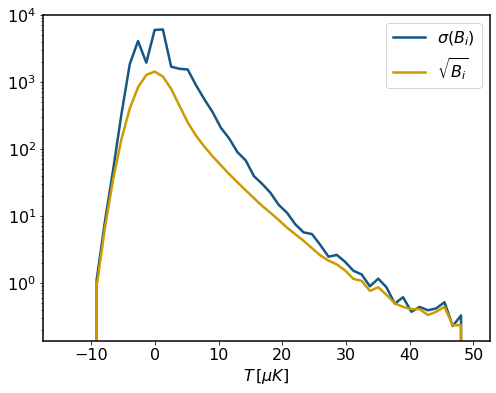

In [10]:
vid_diag = np.std(np.array(Bi50_cut), axis=0)


# vid_diag_theo = Bi_N50[0]
vid_diag_theo = vid_diag

pk_cov = LC.covmat_00.value[kmask]

vid_mask = vid_diag_theo > 0


cov = np.diag(np.hstack([pk_cov, vid_diag_theo[vid_mask]]))


derivvar = np.hstack([pk_deriv, deriv_N50[:,vid_mask]])
vid_vec = np.array(Bi50_cut)[:,vid_mask]

vid_cov = np.corrcoef(vid_vec.T)
plt.figure(facecolor='w')
plt.plot(T50, vid_diag, label=r'$\sigma (B_i)$')
plt.plot(T50, np.sqrt(Bi_N50[0]), label=r'$\sqrt{B_i}$')
plt.xlabel(r'$T\, [\mu K]$')
plt.yscale('log')
plt.legend()

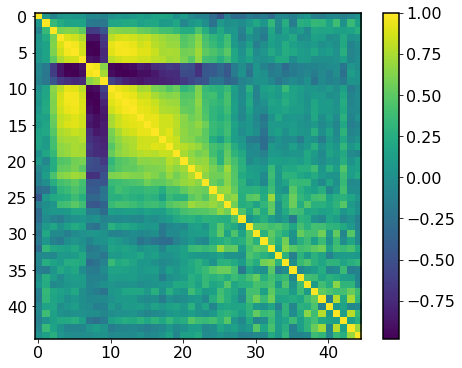

In [11]:
plt.imshow(vid_cov)
plt.colorbar()

# N=50 bins


In [12]:
vid_diag = np.std(np.array(Bi50_cut), axis=0)


# vid_diag_theo = Bi_N50[0]
vid_diag_theo = Bi_N50[0]

pk_cov = LC.covmat_00.value[kmask]

vid_mask = vid_diag_theo > 0


cov = np.diag(np.hstack([pk_cov, vid_diag_theo[vid_mask]]))


derivvar = np.hstack([pk_deriv, deriv_N50[:,vid_mask]])

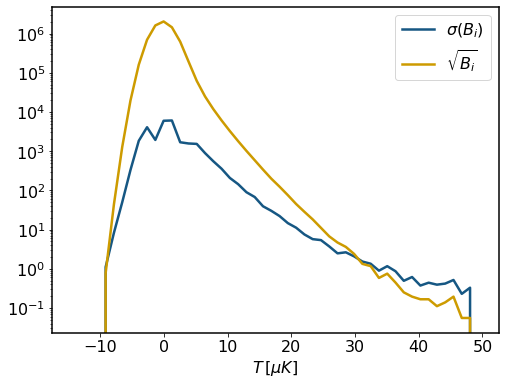

In [13]:
plt.figure(facecolor='w')
plt.plot(T50, vid_diag, label=r'$\sigma (B_i)$')
plt.plot(T50, Bi_N50[0], label=r'$\sqrt{B_i}$')
plt.xlabel(r'$T\, [\mu K]$')
plt.yscale('log')
plt.legend()

Now get covariance and build "Fisher"

In [14]:
vid_diag = np.std(np.array(Bi50_cut), axis=0)


vid_diag_theo = Bi_N50[0]
# vid_diag_theo = vid_diag

pk_cov = LC.covmat_00.value[kmask]

vid_mask = vid_diag_theo > 0


cov = np.diag(np.hstack([pk_cov, vid_diag_theo[vid_mask]]))


derivvar = np.hstack([pk_deriv, deriv_N50[:,vid_mask]])
invcov = np.linalg.inv(cov)




fisher = np.einsum('ik, kp, pj->ij', derivvar, invcov, derivvar.T)


npk = len(pk_deriv[0])
cov_pk = cov[:npk,:npk]

inv_pk = np.linalg.inv(cov_pk)


fisher_pk = np.einsum('ik, kp, pj->ij', derivvar[:,:npk], inv_pk, derivvar[:,:npk].T)


n1 = 0
n2 = np.sum(vid_mask)

cov_vid = cov[npk+n1:npk+n2, npk+n1:npk+n2]

inv_vid = np.linalg.inv(cov_vid)
fisher_vid = np.einsum('ik, kp, pj->ij', derivvar[:,npk+n1:npk+n2], inv_vid, derivvar[:,npk+n1:npk+n2].T)



In [15]:
# np.sqrt(param_all.diagonal())

array([0.00965336, 0.00116553, 1.09447434, 0.00189138])


In [16]:
# np.sqrt(param_vid.diagonal())

# Plot contours

In [17]:
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
from getdist.gaussian_mixtures import GaussianND
plt.rcParams['text.usetex']=False
paramlabels = ['A', 'B', 'C', 'M_h']

# names = ['s8', 'Om', 'b1', 'b2', 'bs2', 'bk2']
# labels =  [r'$\sigma_8$', r'$\Omega_m$', r'$b_1$', r'$b_2$', r'$b_{s^2}$', r'$b_{\nabla^2}$']


param_all = np.linalg.inv(fisher)


param_pk = np.linalg.inv(fisher_pk)

param_vid = np.linalg.inv(fisher_vid)


print('All: ', np.sqrt(param_all.diagonal()))
print('VID: ', np.sqrt(param_vid.diagonal()))

fiducial = popt_bwc


gauss_all= GaussianND(fiducial, param_all,labels=paramlabels,label = r'$P(k) + {\rm VID}$')

gauss_pk = GaussianND(fiducial, param_pk, labels=paramlabels, label=r'$P(k) \,{\rm only}$')

gauss_vid = GaussianND(fiducial, param_vid, labels=paramlabels, label=r'${\rm VID\, only}$')
# fiducial = 

All:  [0.01873399 0.02697039 0.02061434 0.00182203]
VID:  [0.02676775 0.03442011 0.02454042 0.00294553]


In [18]:
# All:  [0.03569435 0.05588457 0.05610188 0.00419412]
# VID:  [0.08998343 0.18623962 0.13381786 0.02624414]

Text(0.5, 0.98, '$N=50$')

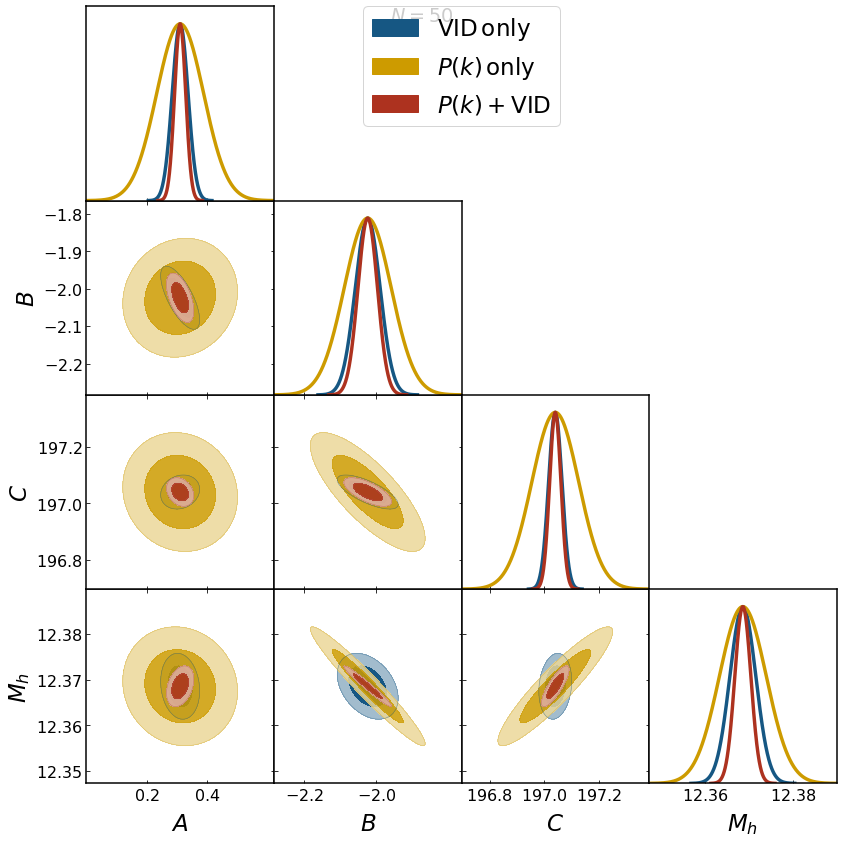

In [19]:
g = plots.get_subplot_plotter(width_inch=12)
g.settings.linewidth=4
g.settings.axes_labelsize=24
g.settings.axes_fontsize=17
g.settings.legend_fontsize=24
g.triangle_plot([gauss_vid, gauss_pk, gauss_all],filled=True,
               line_args=[{'color':'C0'}, {'color':'C1'},{'color':'C2'}], 
    contour_colors=['C0', 'C1', 'C2'])
plt.suptitle(r'$N=50$')

# N=25 bins

In [20]:
vid_diag = np.std(np.array(Bi25_cut), axis=0)


vid_diag_theo = Bi_N25[0]
# vid_diag_theo = vid_diag

pk_cov = LC.covmat_00.value[kmask]

vid_mask = vid_diag_theo > 0


cov = np.diag(np.hstack([pk_cov, vid_diag_theo[vid_mask]]))


derivvar = np.hstack([pk_deriv, deriv_N25[:,vid_mask]])
invcov = np.linalg.inv(cov)




fisher = np.einsum('ik, kp, pj->ij', derivvar, invcov, derivvar.T)


npk = len(pk_deriv[0])
cov_pk = cov[:npk,:npk]

inv_pk = np.linalg.inv(cov_pk)


fisher_pk = np.einsum('ik, kp, pj->ij', derivvar[:,:npk], inv_pk, derivvar[:,:npk].T)


n1 = 0
n2 = np.sum(vid_mask)

cov_vid = cov[npk+n1:npk+n2, npk+n1:npk+n2]

inv_vid = np.linalg.inv(cov_vid)
fisher_vid = np.einsum('ik, kp, pj->ij', derivvar[:,npk+n1:npk+n2], inv_vid, derivvar[:,npk+n1:npk+n2].T)



In [21]:
# from getdist import plots, MCSamples
# import matplotlib.pyplot as plt
# from getdist.gaussian_mixtures import GaussianND
# plt.rcParams['text.usetex']=False
# paramlabels = ['A', 'B', 'C', 'M_h']

# names = ['s8', 'Om', 'b1', 'b2', 'bs2', 'bk2']
# labels =  [r'$\sigma_8$', r'$\Omega_m$', r'$b_1$', r'$b_2$', r'$b_{s^2}$', r'$b_{\nabla^2}$']


param_all = np.linalg.inv(fisher)


param_pk = np.linalg.inv(fisher_pk)

param_vid = np.linalg.inv(fisher_vid)


print('All: ', np.sqrt(param_all.diagonal()))
print('VID: ', np.sqrt(param_vid.diagonal()))

fiducial = popt_bwc


gauss_all= GaussianND(fiducial, param_all,labels=paramlabels,label = r'$P(k) + {\rm VID}$')

gauss_pk = GaussianND(fiducial, param_pk, labels=paramlabels, label=r'$P(k) \,{\rm only}$')

gauss_vid = GaussianND(fiducial, param_vid, labels=paramlabels, label=r'${\rm VID\, only}$')
# fiducial = 

All:  [0.02140496 0.03487957 0.02621127 0.00238254]
VID:  [0.03270249 0.04816399 0.03061421 0.00384165]


Text(0.5, 0.98, '$N=25$')

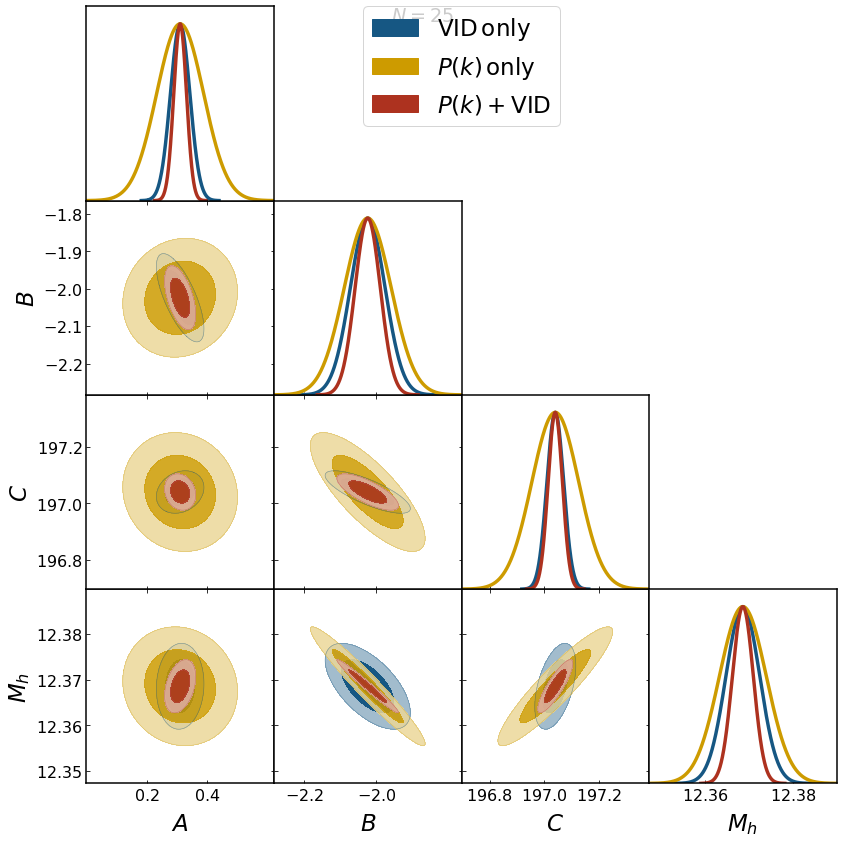

In [22]:
g = plots.get_subplot_plotter(width_inch=12)
g.settings.linewidth=4
g.settings.axes_labelsize=24
g.settings.axes_fontsize=17
g.settings.legend_fontsize=24
g.triangle_plot([gauss_vid, gauss_pk, gauss_all],filled=True,
               line_args=[{'color':'C0'}, {'color':'C1'},{'color':'C2'}], 
    contour_colors=['C0', 'C1', 'C2'])
plt.suptitle(r'$N=25$')

# N=10 bins

In [23]:
vid_diag = np.std(np.array(Bi10_cut), axis=0)


vid_diag_theo = Bi_N10[0]


pk_cov = LC.covmat_00.value[kmask]

vid_mask = vid_diag_theo > 0


cov = np.diag(np.hstack([pk_cov, vid_diag_theo[vid_mask]]))


derivvar = np.hstack([pk_deriv, deriv_N10[:,vid_mask]])
invcov = np.linalg.inv(cov)




fisher = np.einsum('ik, kp, pj->ij', derivvar, invcov, derivvar.T)


npk = len(pk_deriv[0])
cov_pk = cov[:npk,:npk]

inv_pk = np.linalg.inv(cov_pk)


fisher_pk = np.einsum('ik, kp, pj->ij', derivvar[:,:npk], inv_pk, derivvar[:,:npk].T)


n1 = 0
n2 = np.sum(vid_mask)

cov_vid = cov[npk+n1:npk+n2, npk+n1:npk+n2]

inv_vid = np.linalg.inv(cov_vid)
fisher_vid = np.einsum('ik, kp, pj->ij', derivvar[:,npk+n1:npk+n2], inv_vid, derivvar[:,npk+n1:npk+n2].T)



In [24]:
# from getdist import plots, MCSamples
# import matplotlib.pyplot as plt
# from getdist.gaussian_mixtures import GaussianND
# plt.rcParams['text.usetex']=False
# paramlabels = ['A', 'B', 'C', 'M_h']

# names = ['s8', 'Om', 'b1', 'b2', 'bs2', 'bk2']
# labels =  [r'$\sigma_8$', r'$\Omega_m$', r'$b_1$', r'$b_2$', r'$b_{s^2}$', r'$b_{\nabla^2}$']


param_all = np.linalg.inv(fisher)


param_pk = np.linalg.inv(fisher_pk)

param_vid = np.linalg.inv(fisher_vid)


print('All: ', np.sqrt(param_all.diagonal()))
print('VID: ', np.sqrt(param_vid.diagonal()))

fiducial = popt_bwc


gauss_all= GaussianND(fiducial, param_all,labels=paramlabels,label = r'$P(k) + {\rm VID}$')

gauss_pk = GaussianND(fiducial, param_pk, labels=paramlabels, label=r'$P(k) \,{\rm only}$')

gauss_vid = GaussianND(fiducial, param_vid, labels=paramlabels, label=r'${\rm VID\, only}$')
# fiducial = 

All:  [0.02421343 0.04114801 0.02819278 0.00275884]
VID:  [0.04530509 0.07179944 0.03949131 0.00595397]


In [25]:
# All:  [0.03321081 0.05306312 0.04705703 0.00382157]
# VID:  [0.11201399 0.2135529  0.11407097 0.02381587]

Text(0.5, 0.98, '$N=10$')

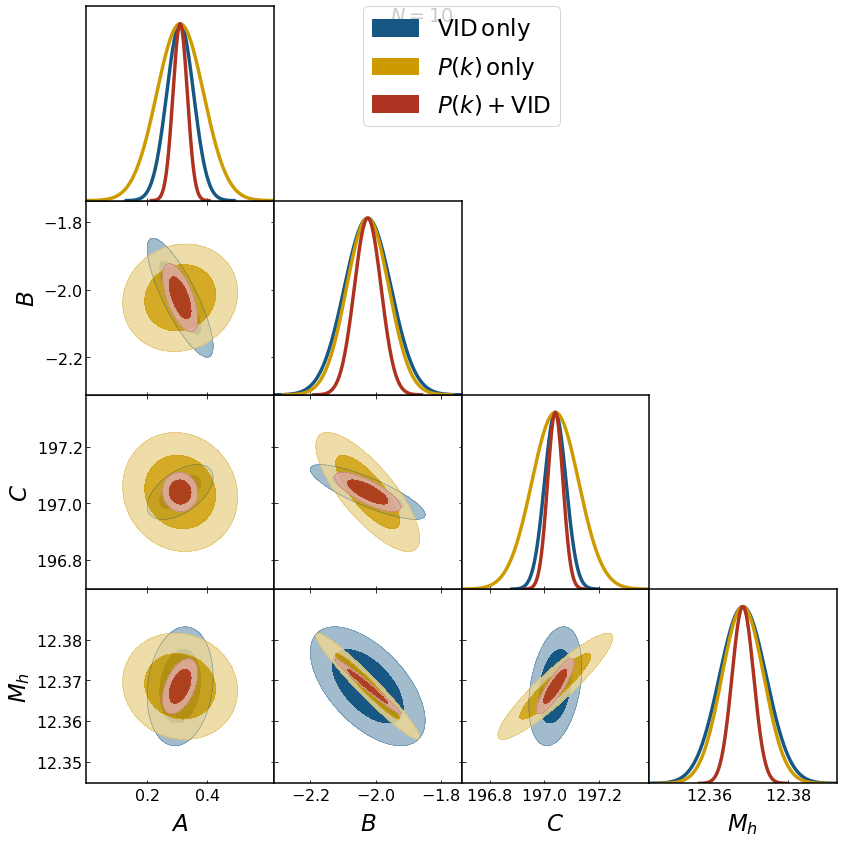

In [26]:
g = plots.get_subplot_plotter(width_inch=12)
g.settings.linewidth=4
g.settings.axes_labelsize=24
g.settings.axes_fontsize=17
g.settings.legend_fontsize=24
g.triangle_plot([gauss_vid, gauss_pk, gauss_all],filled=True,
               line_args=[{'color':'C0'}, {'color':'C1'},{'color':'C2'}], 
    contour_colors=['C0', 'C1', 'C2'])
plt.suptitle(r'$N=10$')